In [12]:
import json
import time
import torch
import numpy as np
import pandas as pd
import dask.dataframe as dd
from PIL import Image
from dask.distributed import Client
from cerebro.dask_backend import DaskBackend
from cerebro.dataset_info import DatasetInfo
from cerebro.params import Params
from cerebro.etl import etl
import cerebro.constants as constants
from torchvision import transforms
from sentence_transformers import SentenceTransformer, util

import matplotlib
from distributed.diagnostics import MemorySampler
from dask.distributed import performance_report

def prepare_data():
    data = None
    with open("/mydata/coco/annotations/captions_val2014.json") as f:
        data = json.load(f)
    dataset = {
        'id': [],
        'file_name': [],
        'height': [],
        'width': [],
        'captions': [],
        'date_captured': [] 
    }

    annotations = {}
    annotations_list = data['annotations']
    for i in annotations_list:
        if not i["image_id"] in annotations:
            annotations[i["image_id"]] = []
        annotations[i["image_id"]].append(i["caption"])

    for i in range(len(data['images'])):
        dataset['id'].append(data["images"][i]['id'])
        dataset['file_name'].append(data["images"][i]['file_name'])
        dataset['height'].append(data["images"][i]['height'])
        dataset['width'].append(data["images"][i]['width'])
        dataset['captions'].append(annotations[data["images"][i]['id']])
        dataset['date_captured'].append(data["images"][i]['date_captured'])

    dataset = pd.DataFrame(dataset)
    dataset.to_csv("/mydata/coco/annotations/captions_val2014_modified.csv", index=False)

def row_preprocessing_routine(row, to_root_path, kwargs):
    t1 = time.time()
    input_image_path = to_root_path + str(row["file_name"])
    output_caption = row["captions"]
    img = Image.open(input_image_path)
    img_tensor = transforms.PILToTensor()(img)
    enc_model = kwargs['nlp_model']
    caption_tensor = enc_model.encode([output_caption], convert_to_tensor=True)
    saved = [img_tensor, caption_tensor]
    t2 = time.time()
    return [ kwargs["io_time"], t2-t1]
    
def testing():
    prepare_data()
    df = pd.read_csv("/mydata/coco/annotations/captions_val2014_modified.csv")
    df.head()

In [13]:
dsk_bknd = DaskBackend("0.0.0.0:8786")

prepare_data()
is_feature_download = [False, True, False, False, False, False]
feature_names = ["id", "file_name", "height", "width", "captions", "date_captured"]
dtypes = (int, str, int, int, list, str)
data_info = DatasetInfo(feature_names, feature_names, [], dtypes, is_feature_download)

metadata_path = "/mydata/coco/annotations/captions_val2014_modified.csv"
from_root_path = "/mydata/coco/images/val2014/"
to_root_path = "/mydata/coco/val2014/"
output_path = ""
requirements_path = ""
download_type = constants.DOWNLOAD_FROM_SERVER
username = "vik1497"
host = "node0"
# host = "128.110.217.142"
pem_path = "/users/vik1497/cloudlab.pem"

nlp_model = SentenceTransformer('all-MiniLM-L6-v2')

params = Params(metadata_path, from_root_path, to_root_path,
    output_path, requirements_path, username, host, pem_path,
    download_type)

e = etl(dsk_bknd, params, row_preprocessing_routine, data_info)

e.load_data(frac=1)
e.shuffle_shard_data()
e.sharded_df.compute()
print(len(e.sharded_df))
result = e.preprocess_data(nlp_model=nlp_model)

Client dashboard:  http://0.0.0.0:8787/status
Number of workers: 32
40504


In [ ]:
with performance_report(filename="./benchmarking/report_3_workers.html"):
    out = result.compute()

In [ ]:

out1.head()

In [ ]:
io_sum = out1["io"].sum()
cpu_sum = out1["cpu"].sum()

In [ ]:
with open("./benchmarking/timings.csv", "a") as f:
    f.write(",".join(["3", str(io_sum), str(cpu_sum)]))
    f.write("\n")

In [3]:
out1 = None

time: -200.3843822479248


<AxesSubplot:xlabel='time', ylabel='Cluster memory (GiB)'>

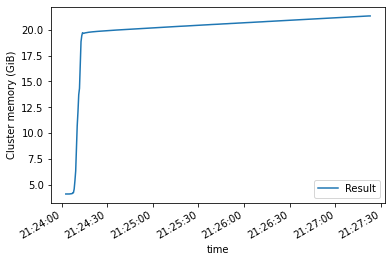

In [14]:
ms = MemorySampler()
with ms.sample("Result"):
    ts = time.time()
    out = result.compute()
    te = time.time()
    out1 = out.copy().to_frame()
    out1[["io", "cpu"]] = list(out1["transformed_data"])
    out1 = out1.drop("transformed_data", axis=1)
    print("time:" , str(ts - te))
# out_df = out.to_frame()
ms.plot()

In [27]:
io_sum = out1["io"].sum()
cpu_sum = out1["cpu"].sum()

In [28]:
io_sum

1626.7873694896698

In [29]:
cpu_sum

4352.840869665146

In [ ]:
76.63276243209839

In [ ]:
for i in range(result.npartitions):
    out1 = result.partitions[i].compute().to_frame()
    out1[["io", "cpu"]] = list(out1["transformed_data"])
    out1 = out1.drop("transformed_data", axis=1)
    io_sum = out1["io"].sum()
    cpu_sum = out1["cpu"].sum()
    print("i:" + str(i) + " io time:"+ str(io_sum))
    print("i:" + str(i) + " cpu time:"+ str(cpu_sum))

i:0 io time:50.16573739051819
i:0 cpu time:96.3658607006073
i:1 io time:51.72825074195862
i:1 cpu time:96.29431509971619
i:2 io time:46.75803518295288
i:2 cpu time:96.02361392974854
i:3 io time:47.50008225440979
i:3 cpu time:95.91982817649841
i:4 io time:48.141329765319824
i:4 cpu time:96.21696496009827
i:5 io time:50.00653028488159
i:5 cpu time:96.51851201057434
i:6 io time:52.34053587913513
i:6 cpu time:95.51170897483826
i:7 io time:51.615744829177856
i:7 cpu time:96.11420822143555
i:8 io time:48.330196380615234
i:8 cpu time:96.32715463638306
i:9 io time:51.3413565158844
i:9 cpu time:96.63238430023193
i:10 io time:50.394219636917114
i:10 cpu time:95.51739692687988
i:11 io time:48.186307191848755
i:11 cpu time:95.29490041732788
i:12 io time:48.865437030792236
i:12 cpu time:96.40552139282227
i:13 io time:49.719459772109985
i:13 cpu time:96.06203818321228
i:14 io time:50.20809364318848
i:14 cpu time:97.32974171638489
i:15 io time:49.73141622543335
i:15 cpu time:95.81811666488647


In [21]:
out1

1228      [0.24522733688354492, 0.0664372444152832]
165      [0.05618453025817871, 0.06711816787719727]
1189     [0.06087231636047363, 0.09096956253051758]
271     [0.017115116119384766, 0.06724071502685547]
441     [0.056533098220825195, 0.06775879859924316]
                           ...                     
926      [0.05424356460571289, 0.06626605987548828]
696     [0.014594554901123047, 0.06103396415710449]
358     [0.014006853103637695, 0.07684445381164551]
254     [0.013506174087524414, 0.06275391578674316]
458     [0.059103965759277344, 0.07337403297424316]
Name: transformed_data, Length: 1266, dtype: object

In [25]:
out1["transformed_data"]

KeyError: 'transformed_data'